In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler

/opt/homebrew/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Loading data

In [4]:
# Download data here : https://downloads.viscoda.com/research/roadsaw/log.txt

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set the path to your dataset
data_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/MergedDataset'

# Define the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    horizontal_flip=True,
    zoom_range=[0.9, 1.1],  # Scaling [90%, 110%]
    width_shift_range=[-0.1, 0.1],  # Shifting horizontally [-10%, 10%]
    height_shift_range=[-0.1, 0.1],  # Shifting vertically [-10%, 10%]
    shear_range=0.1,  # Shearing [-10%, 10%]
)

# Use the flow_from_directory method to load and augment the data
batch_size = 32
class_names = sorted(os.listdir(data_path))

# Set image size and number of classes
img_size = (224, 224)
num_classes = len(class_names)

#number of epochs
num_epochs = 10

#initial learning rates of two phases
init_lr_1 = 0.001
init_lr_2 = 1e-5

# Load the data and split it into training, validation, and test sets
# Assuming the structure of your dataset is as follows:
# data_path
# ├── class1
# ├── class2
# ├── class3
# ├── class4
# ├── class5
# ├── class6
data_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Split the data into training, validation, and test sets
# Adjust the test_size and validation_size according to your preference
X_train, X_temp, y_train, y_temp = train_test_split(
    data_generator.filenames,
    data_generator.classes,
    test_size=0.2,
    random_state=42,
    stratify=data_generator.classes
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Print the number of samples in each set
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Found 19788 images belonging to 6 classes.
Train samples: 15830
Validation samples: 1979
Test samples: 1979


In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')

In [6]:
#Freeze the layers of the base network
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Create your own model on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

opt1 = tfa.optimizers.RectifiedAdam(learning_rate=init_lr_1)

model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a function to compute the learning rate schedule
def lr_schedule(epoch, initial_lr):
    return initial_lr * 0.9 ** epoch

lr_callback1 = LearningRateScheduler(lambda epoch: lr_schedule(epoch, init_lr_1), verbose=1)

In [8]:
#Phase 1 
hist1 = model.fit(data_generator,steps_per_epoch=len(X_train)//batch_size, epochs=num_epochs, validation_data=(X_val,y_val), validation_steps = len(X_val) //batch_size)

Epoch 1/10
494/494 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.7409

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'str'>"}), <class 'numpy.ndarray'>

In [ ]:
# # Unfreeze the convolutional base for fine-tuning
# for layer in base_model.layers:
#     layer.trainable = True

# opt2 = tfa.optimizers.RectifiedAdam(learning_rate=init_lr_2-5)
# # Lower the learning rate for fine-tuning
# model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

# lr_callback1 = LearningRateScheduler(lambda epoch: lr_schedule(epoch, init_lr_2), verbose=1)

In [ ]:
#Phase 2 
# hist2 = model.fit(train_generator, epochs=num_epochs, callbacks=[lr_callback1],validation_data=validation_generator)

In [ ]:
#Save the model 
model.save(os.path.join('models','RW6lclassifierV1.keras'))

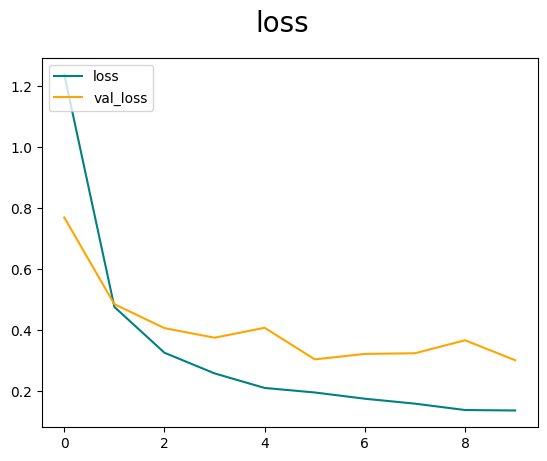

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist1.history['loss'],color='teal',label='loss')
plt.plot(hist1.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

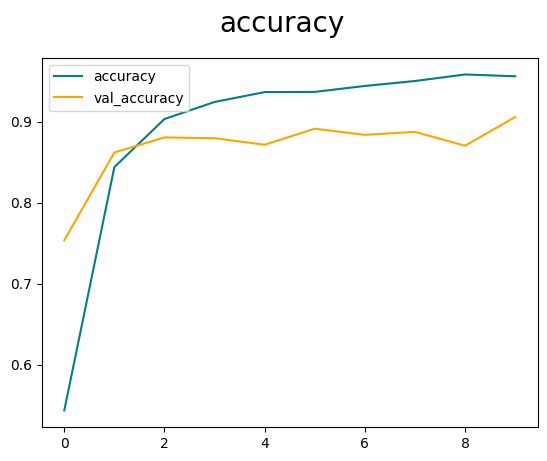

In [ ]:
fig = plt.figure()
plt.plot(hist1.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist1.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

# Assuming you have already trained and saved your model
model = load_model('models/RW6lclassifierV1.keras')

# Use the test_generator to generate predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test_generator
y_true = y_test

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_labels)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
print(f'Confusion Matrix:\n{conf_matrix}')

# Calculate precision, recall, and F1-score
class_report = classification_report(y_true, y_pred_labels)
print(f'Classification Report:\n{class_report}')


55/55 [==============================] - 40s 716ms/step
Accuracy: 0.15296803652968036
Confusion Matrix:
[[59 71 30 25 59 48]
 [54 59 40 19 58 62]
 [63 70 23 13 53 70]
 [55 71 39 13 50 64]
 [48 79 32 20 63 50]
 [63 67 26 22 63 51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.20      0.19       292
           1       0.14      0.20      0.17       292
           2       0.12      0.08      0.10       292
           3       0.12      0.04      0.06       292
           4       0.18      0.22      0.20       292
           5       0.15      0.17      0.16       292

    accuracy                           0.15      1752
   macro avg       0.15      0.15      0.14      1752
weighted avg       0.15      0.15      0.14      1752



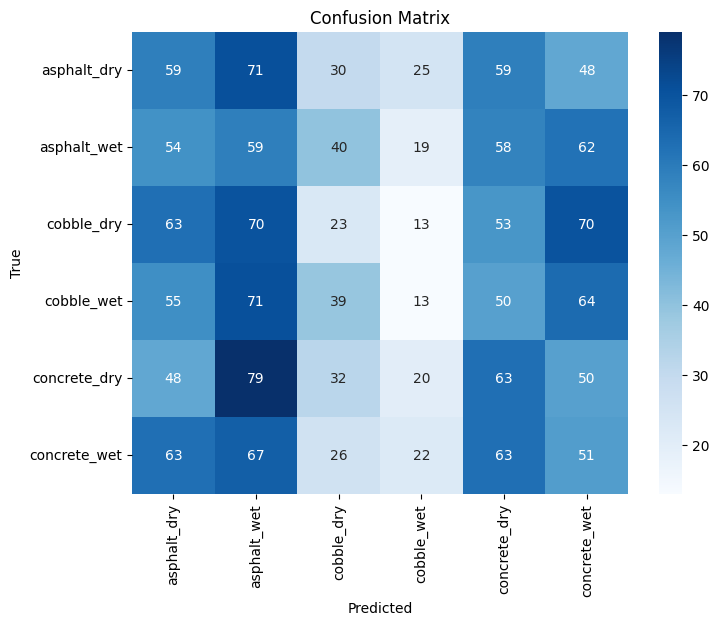

In [ ]:
# import seaborn as sns
# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

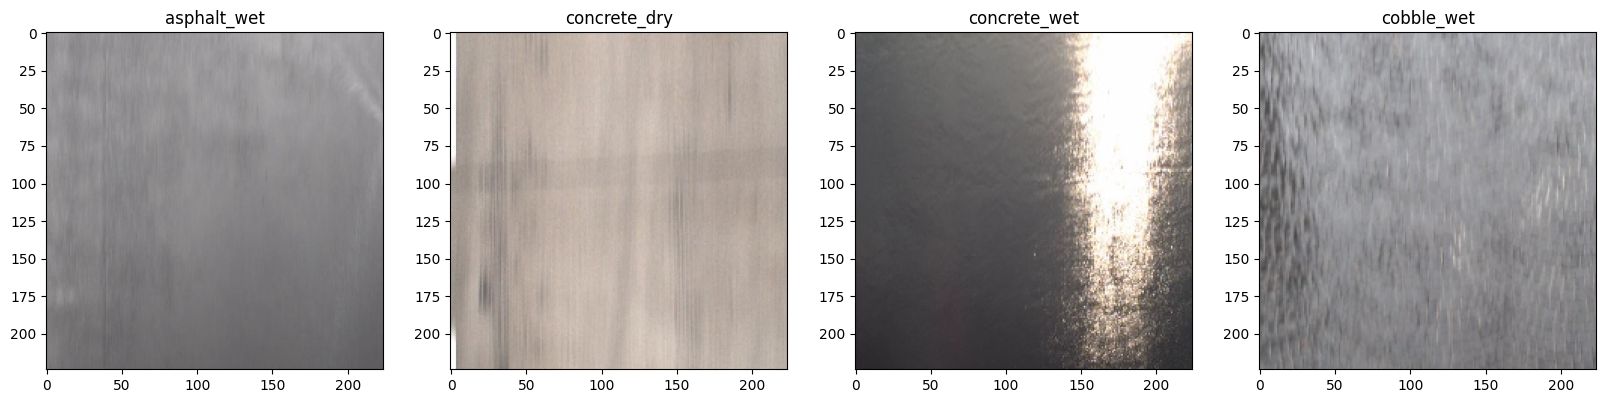

In [ ]:
batch = test_generator.next()
images = batch[0]
labels = batch[1]

fig, ax = plt.subplots(ncols=4,figsize =(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx].argmax()])

In [ ]:
# from tensorflow.keras.metrics import Precision,Recall,Accuracy

# pre = Precision()
# re = Recall()
# acc = Accuracy()

# for i in range(len(test_generator)):
#     x_test_batch, y_test_batch = next(test_generator)
#     yhat = model.predict(x_test_batch)
#     pre.update_state(y_test_batch,yhat)
#     re.update_state(y_test_batch,yhat)
#     acc.update_state(y_test_batch,yhat)

# print(f"Precision {pre.result().numpy()} , Recall {re.result().numpy()} , Accuracy {acc.result().numpy()}")

1/1 [==============================] - 0s 176ms/step
Precision 0.6745702624320984 , Recall 0.6495434045791626 , Accuracy 0.0031392693053931
